# Introduction to dynamic circuits

This tutorial introduces the current dynamic circuit support through Qiskit on IBM Quantum hardware.

Dynamic circuits are quantum circuits that contain mid-circuit measurements that affect the control flow of gate execution later in the circuit, otherwise known as feed-forward operations. The canonical and most simple example is conditional reset, where we perform a projective measurement of the qubit, and if the result is a 1, we flip the state using an X-gate from the $|1\rangle$ to the $|0\rangle$ state. If the result is a 0 we do nothing, as we are already in $|0\rangle$.

Dynamic circuit support requires significant changes to the hardware and software backends that execute quantum circuits, compared to traditional 'static' circuits. Many of IBM Quantum's hardware backends have been upgraded to support dynamic circuits. To view the simulators and systems supporting dynamic circuits that you can access, [click here (requires the user to be logged in to IBM Quantum)](https://quantum-computing.ibm.com/services/resources?tab=yours&openqasm3=true). Support for dynamic circuits will continue to grow and improve in ease of use and efficiency. We aim to keep the tutorials in this documentation up to date with what IBM's hardware and software backends provide.

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Run a dynamic circuit

**Note**: Before running this notebook, make sure to the follow the steps in the [Getting started with dynamic circuits](./Getting-started-with-Dynamic-Circuits) guide, to verify you are set up to run dynamic circuit programs on IBM hardware.

### Step 1: Load backend

Backends provide a handle to the quantum hardware instance. The main approach for running circuits will be to call `backend.run(<your circuit>, dynamic=True)`. Backends are obtained from the ``IBMProvider`` imported from ``qiskit_ibm_provider``, and are specified by a system name along with the ``hub/group/project`` string that gives you access to that system.

In [2]:
# Note: This can be any hub/group/project that has access to the required device and Qiskit Runtime.
hub = "<hub>"
group = "<group>"
project = "<project>"
backend_name = "<your backend>"
hgp = f"{hub}/{group}/{project}"

In [3]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

**Load a simulator backend**

We can also use a simulator to simulate the behavior of dynamic circuits. We obtain a simulator backend similarly to a hardware backend.

In [4]:
from qiskit import Aer

backend_sim = Aer.get_backend("aer_simulator")

### Step 2: Write a dynamic circuit with Qiskit

We start with a conditional reset circuit on a single qubit. We first try to excite the qubit with an X-gate followed by a  measurement, and another X-gate if the measurement returns a 1.

In older versions of Qiskit, limited conditional execution was supported using the `c_if()` construct. This was a function that all gate objects exposed, which allowed gate execution to be conditioned on the value of a classical register. A significant limitation was that only a single gate could be conditioned on the classical register value.

In contrast, the new style of classical control flow with the `if_test()` allows significantly more flexibility in the values that can be conditioned on and the sub-circuits that can be defined within the body of the `if_test()`. It also enables ``else`` conditions. More documentation on the `if_test()` is [available here](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html).

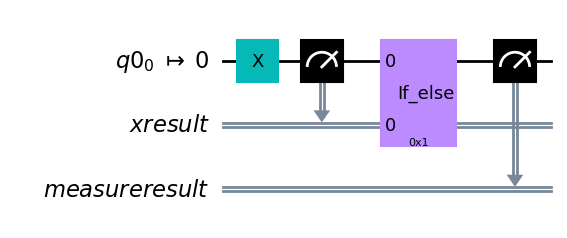

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

qr = QuantumRegister(1)
crx = ClassicalRegister(1, name="xresult")
crm = ClassicalRegister(1, name="measureresult")
qc_reset = QuantumCircuit(qr, crx, crm, name="Reset")
qc_reset.x(0)
qc_reset.measure(0, crx)
# qc_reset.x(0).c_if(crx, 1) # old style conditional gate
with qc_reset.if_test((crx, 1)):  # new style conditional block (more flexible)
    qc_reset.x(0)
qc_reset.measure(0, crm)

qc_reset = transpile(qc_reset, backend, initial_layout=[0])
qc_reset.draw(output="mpl", idle_wires=False)

### Step 3: Run conditional reset in a simulator

Running on the simulator is very similar to running on the hardware.

In [6]:
reset_sim_job = backend_sim.run(qc_reset)
print(reset_sim_job.job_id())

0191006e-ab5e-41bd-bff3-734e3dd5f2d1


In [7]:
reset_sim_result = reset_sim_job.result()
reset_sim_counts = reset_sim_result.get_counts(0)
print(f"Full counts including reset: {reset_sim_counts}")

Full counts including reset: {'0 1': 1024}


### Step 4: Run conditional reset on hardware

Now we run our conditional reset program on the backend. We turn off the automatic qubit initialization provided by the backend so that we can examine the results of our reset program directly.

In [8]:
reset_job = backend.run(
    qc_reset, dynamic=True, init_qubits=False
)  # Turn off automatic init
print(reset_job.job_id())

cgdmfj3svrampimk6nb0


Let's understand the results:

In [9]:
from qiskit.result import marginal_counts

reset_result = reset_job.result()
reset_counts = reset_result.get_counts(0)
mitigated_reset_results = marginal_counts(reset_counts, indices=[1])
print(f"Full counts including reset: {reset_counts}")
print(
    f"Results from our reset - |0>s prepared {mitigated_reset_results.get('0')}, |1>s prepared {mitigated_reset_results['1']}"
)

Full counts including reset: {'0 0': 89, '0 1': 3648, '1 0': 14, '1 1': 249}
Results from our reset - |0>s prepared 3737, |1>s prepared 263


### Step 5: Conditional Reset with OpenQASM 3

Another way to write the same circuit above is to use [OpenQASM 3](https://arxiv.org/abs/2104.14722), a quantum assembly language well-suited to describing dynamic circuits. The [live specification](https://openqasm.com/) provides full details. Qiskit provides support to directly convert `QuantumCircuit` objects into OpenQASM 3.0 strings.

In [10]:
try:
    from qiskit import qasm3
except ImportError:
    print(
        "You likely do not have the latest version of Qiskit installed. Please install it to run this code"
    )
    raise


def dump_qasm3(circuit, backend=backend):
    return qasm3.Exporter(
        includes=[],
        basis_gates=backend.configuration().basis_gates,
        disable_constants=True,
    ).dumps(circuit)


qc_reset_qasm3 = dump_qasm3(qc_reset)
print(qc_reset_qasm3)

OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $0;
xresult[0] = measure $0;
if (xresult == 1) {
  x $0;
}
measureresult[0] = measure $0;



**Note:** The names of the classical registers (`xresult` and `measureresult`) in the ``qasm3`` string above are the same as those provided when the circuit was first constructed. These make the OpenQASM 3 string much more human-readable.

### Step 6: Submit an OpenQASM 3 string directly

It is also possible to submit an OpenQASM 3 string directly instead of a `QuantumCircuit` object.

This is useful when the `QuantumCircuit` does not yet support all of the semantics of OpenQASM 3. To see what features of OpenQASM 3 are currently supported in hardware, please see the [feature support table here](https://quantum-computing.ibm.com/services/docs/services/manage/systems/dynamic-circuits/feature-table).

See [Dynamic-Circuits-basics-with-OpenQASM3](https://quantum-computing.ibm.com/lab/files/qiskit-tutorials/dynamic-circuits/Dynamic-Circuits-basics-with-OpenQASM3.ipynb) for more information.

**Note**: We cannot use circuit merging when OpenQASM 3 source strings are submitted. In this case each OpenQASM 3 source will run individually.

In [11]:
qasm3_job = backend.run(qc_reset_qasm3, dynamic=True)
print(qasm3_job.job_id())

cgdmfnni6ptf3jkq98ug


In [12]:
print(qasm3_job.result().get_counts())

{'0': 96, '1': 3662, '10': 9, '11': 233}


---

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table